# Only the mathematical trading strategy for getting the signals

In [9]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## Dataset

In [53]:
df_3m = pd.read_csv('datasets/btc_3m.csv')
df_3m['datetime'] = pd.to_datetime(df_3m['datetime'])
df_3m.set_index('datetime', inplace=True)
df_3m

,open,high,low,close,volume
datetime,,,,,
2018-01-01 05:30:00,13715.65,13715.65,13666.11,13680.00,6.303815
2018-01-01 05:33:00,13679.98,13679.98,13554.44,13568.00,33.709206
2018-01-01 05:36:00,13568.00,13575.00,13501.01,13575.00,29.645987
2018-01-01 05:39:00,13539.99,13575.00,13400.01,13515.26,30.696039
2018-01-01 05:42:00,13515.26,13568.66,13473.47,13556.15,23.260966
...,...,...,...,...,...
2022-01-31 05:18:00,37919.05,37919.05,37876.94,37891.30,30.717900
2022-01-31 05:21:00,37891.30,37946.56,37870.00,37918.80,28.369420
2022-01-31 05:24:00,37918.79,37948.79,37888.88,37898.01,22.346010


In [54]:
def filter_df(df, start_date, end_date):
    subset_df = df.loc[start_date:end_date]
    return subset_df

start_date = '2018-01-01'
end_date = '2018-4-01'
filtetred_df_3m = filter_df(df_3m, start_date, end_date)
print(filtetred_df_3m.shape)
filtetred_df_3m.iloc[[0,-1],:]

(42844, 5)


,open,high,low,close,volume
datetime,,,,,
2018-01-01 05:30:00,13715.65,13715.65,13666.11,13680.00,6.303815
2018-04-01 23:57:00,6783.66,6785.00,6768.05,6768.05,211.924933


In [3]:
filtetred_df_3m = df_3m.copy()

In [ ]:
def plot_candlestick_chart(df,num_candles=-1):
    if num_candles != -1:
        df = df.iloc[:num_candles]
    
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

    # Customize the layout
    fig.update_layout(title='Candlestick chart',
                    xaxis_title='Date and Time',
                    yaxis_title='Price data',
                    xaxis_rangeslider_visible=False)

    # Show the plot
    fig.show()

In [ ]:
plot_candlestick_chart(df_3m)

### Adding the indicators

In [76]:
def add_indicators(df):
    # SMA
    df['SMA_20'] = df['close'].rolling(window=20).mean()
    df['SMA_50'] = df['close'].rolling(window=50).mean()
    
    # RSI
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()

    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Moving Average Convergence Divergence (MACD)
    short_window = 12
    long_window = 26
    signal_window = 9

    exp_short = df['close'].ewm(span=short_window, adjust=False).mean()
    exp_long = df['close'].ewm(span=long_window, adjust=False).mean()

    df['MACD'] = exp_short - exp_long
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

    # Bollinger Bands
    window = 20
    df['Upper_Band'] = df['SMA_20'] + 2 * df['close'].rolling(window=window).std()
    df['Lower_Band'] = df['SMA_20'] - 2 * df['close'].rolling(window=window).std()

    # ATR
    # Calculate True Range (TR)
    df['High-Low'] = df['high'] - df['low']
    df['High-PrevClose'] = abs(df['high'] - df['close'].shift(1))
    df['Low-PrevClose'] = abs(df['low'] - df['close'].shift(1))

    df['TrueRange'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)

    # Choose the ATR period (e.g., 14 days)
    atr_period = 14

    # Calculate ATR using rolling mean
    df['ATR'] = df['TrueRange'].rolling(window=atr_period).mean()

    # Drop intermediate columns used for calculation
    df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose', 'TrueRange'], axis=1, inplace=True)

    # Removing null rows
    df = df.dropna()
    return df

In [77]:
test_df = add_indicators(filtetred_df_3m)
print(test_df.shape)
# test_df.iloc[[0,-1],:]
test_df

(42795, 16)


C:\Users\sanya\AppData\Local\Temp\ipykernel_8820\553361634.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA_20'] = df['close'].rolling(window=20).mean()
C:\Users\sanya\AppData\Local\Temp\ipykernel_8820\553361634.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA_50'] = df['close'].rolling(window=50).mean()
C:\Users\sanya\AppData\Local\Temp\ipykernel_8820\553361634.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,open,high,low,close,volume,SMA_14,SMA_20,RSI,MACD,Signal_Line,Upper_Band,Lower_Band,ATR,StopLoss,TakeProfit,SMA_50
datetime,,,,,,,,,,,,,,,,
2018-01-01 07:57:00,13308.00,13323.97,13225.00,13225.00,21.656899,13312.493571,13360.8155,41.444909,-57.163918,-53.574739,13555.528164,13166.102836,93.252143,13085.121786,13411.504286,13457.1630
2018-01-01 08:00:00,13247.80,13297.05,13200.00,13268.92,17.515930,13303.130714,13347.7695,42.982268,-57.088806,-54.277553,13529.317459,13166.221541,93.683571,13128.394643,13456.287143,13448.9414
2018-01-01 08:03:00,13268.92,13349.99,13202.03,13294.55,40.327491,13300.955714,13336.4970,48.278786,-54.334815,-54.289005,13500.130723,13172.863277,98.538571,13146.742143,13491.627143,13443.4724
2018-01-01 08:06:00,13294.00,13304.98,13210.00,13225.73,19.097106,13300.620714,13321.7850,49.726941,-57.047844,-54.840773,13467.938564,13175.631436,96.450714,13081.053929,13418.631429,13436.4870
2018-01-01 08:09:00,13222.36,13245.20,13211.72,13226.10,10.836985,13302.266429,13310.5410,51.384948,-58.493803,-55.571379,13449.256783,13171.825217,93.478571,13085.882143,13413.057143,13430.7038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01 23:45:00,6826.00,6826.00,6793.00,6798.08,91.961011,6822.765000,6816.5630,55.256192,16.708673,23.296810,6856.996137,6776.129863,29.490000,6753.845000,6857.060000,6756.6162
2018-04-01 23:48:00,6798.08,6835.47,6793.00,6818.00,119.890550,6824.055714,6816.2365,55.308773,15.297459,21.696940,6856.503877,6775.969123,30.528571,6772.207143,6879.057143,6763.5702
2018-04-01 23:51:00,6819.37,6819.38,6785.01,6799.78,104.573571,6824.347857,6814.8910,51.110387,12.564030,19.870358,6855.484690,6774.297310,31.232143,6752.931786,6862.244286,6769.6058


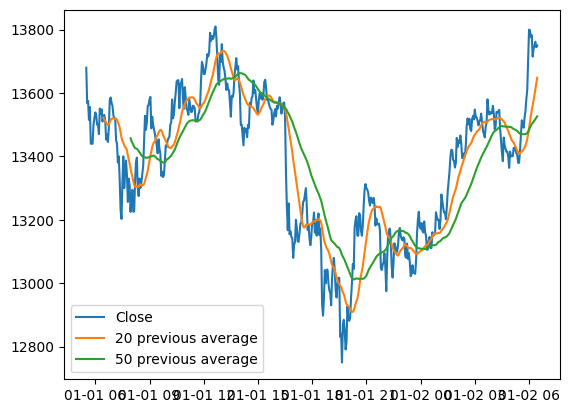

In [79]:
plt.plot(filtetred_df_3m['close'].iloc[:500],label="Close")
plt.plot(filtetred_df_3m['SMA_20'].iloc[:500],label="20 previous average")
plt.plot(filtetred_df_3m['SMA_50'].iloc[:500],label="50 previous average")
plt.legend()

## Strategy

In [98]:
usd = 10000
btc = 0

# Define trading parameters
atr_factor = 1.5
take_profit_factor = 2
stop_loss = 0  # Stop-loss at 2%
target = 0  # Target at 5%

# Initialize columns for signals and balances
test_df['Signal'] = ''
test_df['Balance_USD'] = 10000
test_df['Balance_BTC'] = 0
signal = ''
# Trading loop
for i in range(1, len(test_df)):
    # Buy condition
    if btc == 0:
        if (
            test_df['SMA_14'][i] > test_df['SMA_20'][i] 
            # test_df['RSI'][i] < 30 or
            # test_df['MACD'][i] > test_df['Signal_Line'][i] or
            # test_df['close'][i] < test_df['Lower_Band'][i]
        ):
            # Buy BTC with all available USD
            btc = (usd - usd * .15) / test_df['close'][i]
            usd = 0
            signal = 'Buy'
            # Set the stop loss and target
            stop_loss = test_df['close'][i] - (atr_factor * test_df['ATR'][i])
            target = test_df['close'][i] + (take_profit_factor * test_df['ATR'][i])
        else:
            signal = "Wait"
    
    # Sell condition
    elif btc > 0:
        if test_df['close'][i] <= stop_loss or test_df['close'][i] >= target:
            usd = btc * test_df['close'][i]
            btc = 0
            signal = 'Sell'
        elif (
            test_df['SMA_14'][i] < test_df['SMA_20'][i] 
            # test_df['RSI'][i] > 70 or
            # test_df['MACD'][i] < test_df['Signal_Line'][i] or
            # test_df['close'][i] > test_df['Upper_Band'][i]
        ):
            # Sell all BTC and convert to USD
            usd = btc * test_df['close'][i]
            btc = 0
            signal = 'Sell'
        else:
            signal = "Hold"
    
    # Update DataFrame
    test_df.at[test_df.index[i], 'Signal'] = signal
    test_df.at[test_df.index[i], 'Balance_USD'] = usd
    test_df.at[test_df.index[i], 'Balance_BTC'] = btc

test_df

C:\Users\sanya\AppData\Local\Temp\ipykernel_8820\1542160976.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Signal'] = ''
C:\Users\sanya\AppData\Local\Temp\ipykernel_8820\1542160976.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Balance_USD'] = 10000
C:\Users\sanya\AppData\Local\Temp\ipykernel_8820\1542160976.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

,open,high,low,close,volume,SMA_14,SMA_20,RSI,MACD,Signal_Line,Upper_Band,Lower_Band,ATR,StopLoss,TakeProfit,SMA_50,Signal,Balance_USD,Balance_BTC
datetime,,,,,,,,,,,,,,,,,,,
2018-01-01 07:57:00,13308.00,13323.97,13225.00,13225.00,21.656899,13312.493571,13360.8155,41.444909,-57.163918,-53.574739,13555.528164,13166.102836,93.252143,13085.121786,13411.504286,13457.1630,,1.000000e+04,0.000000e+00
2018-01-01 08:00:00,13247.80,13297.05,13200.00,13268.92,17.515930,13303.130714,13347.7695,42.982268,-57.088806,-54.277553,13529.317459,13166.221541,93.683571,13128.394643,13456.287143,13448.9414,Wait,1.000000e+04,0.000000e+00
2018-01-01 08:03:00,13268.92,13349.99,13202.03,13294.55,40.327491,13300.955714,13336.4970,48.278786,-54.334815,-54.289005,13500.130723,13172.863277,98.538571,13146.742143,13491.627143,13443.4724,Wait,1.000000e+04,0.000000e+00
2018-01-01 08:06:00,13294.00,13304.98,13210.00,13225.73,19.097106,13300.620714,13321.7850,49.726941,-57.047844,-54.840773,13467.938564,13175.631436,96.450714,13081.053929,13418.631429,13436.4870,Wait,1.000000e+04,0.000000e+00
2018-01-01 08:09:00,13222.36,13245.20,13211.72,13226.10,10.836985,13302.266429,13310.5410,51.384948,-58.493803,-55.571379,13449.256783,13171.825217,93.478571,13085.882143,13413.057143,13430.7038,Wait,1.000000e+04,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01 23:45:00,6826.00,6826.00,6793.00,6798.08,91.961011,6822.765000,6816.5630,55.256192,16.708673,23.296810,6856.996137,6776.129863,29.490000,6753.845000,6857.060000,6756.6162,Hold,0.000000e+00,9.500089e-181
2018-04-01 23:48:00,6798.08,6835.47,6793.00,6818.00,119.890550,6824.055714,6816.2365,55.308773,15.297459,21.696940,6856.503877,6775.969123,30.528571,6772.207143,6879.057143,6763.5702,Hold,0.000000e+00,9.500089e-181
2018-04-01 23:51:00,6819.37,6819.38,6785.01,6799.78,104.573571,6824.347857,6814.8910,51.110387,12.564030,19.870358,6855.484690,6774.297310,31.232143,6752.931786,6862.244286,6769.6058,Hold,0.000000e+00,9.500089e-181


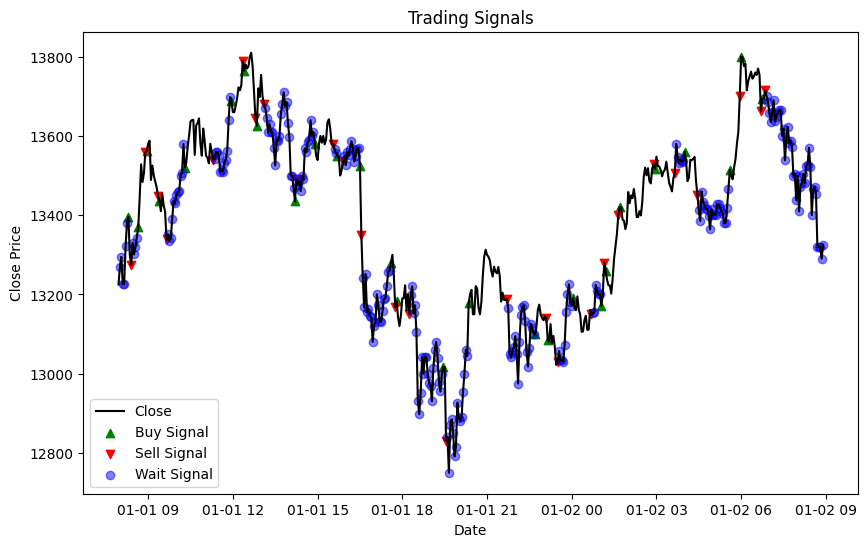

In [99]:
plot_df = test_df.iloc[:500,:]
plt.figure(figsize=(10, 6))

# Plot close values
plt.plot(plot_df.index, plot_df['close'], label='Close', color='black')

# Marking Buy signals with green upward arrows
plt.scatter(plot_df[plot_df['Signal'] == 'Buy'].index, plot_df[plot_df['Signal'] == 'Buy']['close'], label='Buy Signal', marker='^', color='g', alpha=1)

# Marking Sell signals with red downward arrows
plt.scatter(plot_df[plot_df['Signal'] == 'Sell'].index, plot_df[plot_df['Signal'] == 'Sell']['close'], label='Sell Signal', marker='v', color='r', alpha=1)

# Marking Wait signals with blue circles
plt.scatter(plot_df[plot_df['Signal'] == 'Wait'].index, plot_df[plot_df['Signal'] == 'Wait']['close'], label='Wait Signal', marker='o', color='b', alpha=0.5)

plt.title('Trading Signals')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()